In [7]:
# Importing necessary libraries (NumPy, Pandas, Matplotlib)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter, defaultdict
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


np.random.seed(42)
random.seed(42)

In [10]:

df = pd.read_csv('dataset/spam.csv', encoding='latin-1')

In [11]:
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (5572, 5)

First 5 rows:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [12]:
print("\nColumn information:")
print(df.info())


Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [13]:

print("\nMissing values:")
print(df.isnull().sum())


Missing values:
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [14]:

#dropping missing values and finalizing dataset 
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, errors='ignore')
df = df.rename(columns={'v1': 'label', 'v2': 'message'})

print("\nCleaned dataset:")
print(df.head())


Cleaned dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [15]:
# Exploring Dataset
print("\nClass distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True) * 100)


Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


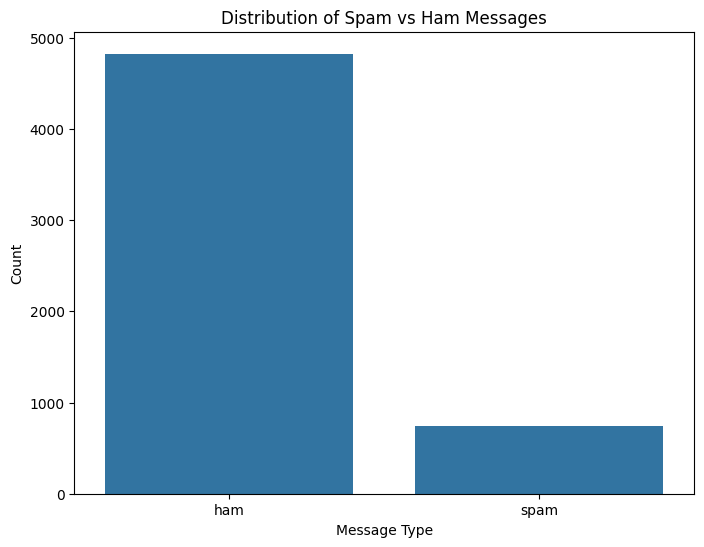

In [16]:
# class chart
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

In [17]:
# Analyze message lengths
df['length'] = df['message'].apply(len)
print("\nMessage length statistics:")
print(df.groupby('label')['length'].describe())


Message length statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


C:\Users\mcsmu\AppData\Local\Temp\ipykernel_2256\1415111952.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Message Type')


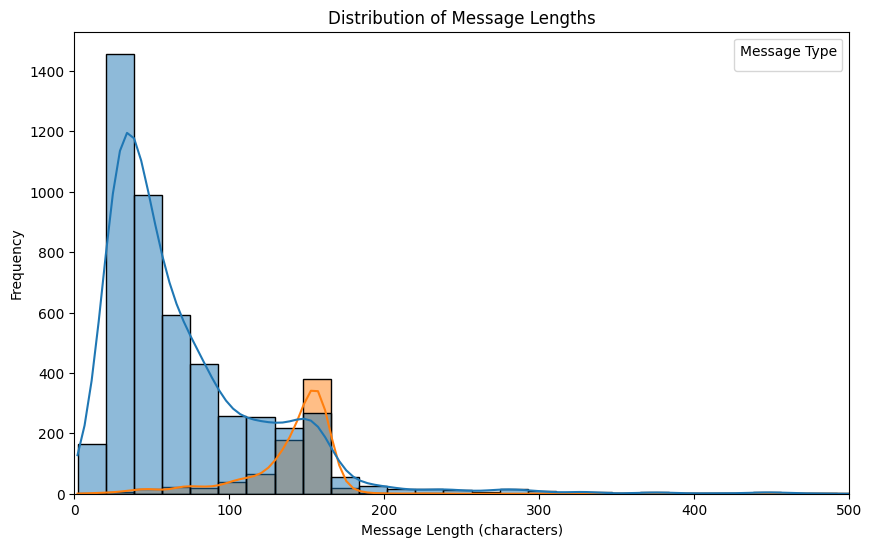

In [18]:
# Visualize message lengths by class
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='label', bins=50, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.xlim(0, 500)  # Limit x-axis for better visualization
plt.legend(title='Message Type')
plt.show()

In [19]:
# Look at some examples of spam and ham messages
print("\nExample of Ham messages:")
print(df[df['label'] == 'ham'].head(3)['message'].values)

print("\nExample of Spam messages:")
print(df[df['label'] == 'spam'].head(3)['message'].values)


Example of Ham messages:
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'
 'Ok lar... Joking wif u oni...'
 'U dun say so early hor... U c already then say...']

Example of Spam messages:
["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"
 'WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.']


In [20]:
# Convert labels to binary format (1 for spam, 0 for ham)
df['label_num'] = df['label'].map({'spam': 1, 'ham': 0})

In [21]:
# 3. Implementing Preprocessing Functions

def tokenize_text(message):
    """
    Convert a message to lowercase, remove punctuation, and split into words.
    
    Args:
        message (str): The text message to tokenize
        
    Returns:
        list: A list of tokens (words)
    """
    # Convert to lowercase
    message = message.lower()
    
    # Remove punctuation
    message = re.sub(f'[{string.punctuation}]', ' ', message)
    
    # Remove numbers (optional, comment if you want to keep numbers)
    message = re.sub(r'\d+', '', message)
    
    # Split into words and remove extra whitespaces
    tokens = message.split()
    
    return tokens

# Define a list of English stop words
STOP_WORDS = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
    'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 
    'will', 'just', 'don', 'should', 'now'
]

def remove_stopwords(tokens):
    """
    Remove common stopwords from the token list.
    
    Args:
        tokens (list): List of tokens (words)
        
    Returns:
        list: Filtered list with stopwords removed
    """
    return [word for word in tokens if word not in STOP_WORDS]

In [22]:
# Test the preprocessing functions on a sample message
sample_message = "Hello! This is a sample message with some numbers 123. Is it working?"
tokens = tokenize_text(sample_message)
filtered_tokens = remove_stopwords(tokens)

print("\nPreprocessing example:")
print("Original message:", sample_message)
print("After tokenization:", tokens)
print("After stopword removal:", filtered_tokens)


Preprocessing example:
Original message: Hello! This is a sample message with some numbers 123. Is it working?
After tokenization: ['hello', 'this', 'is', 'a', 'sample', 'message', 'with', 'some', 'numbers', 'is', 'it', 'working']
After stopword removal: ['hello', 'sample', 'message', 'numbers', 'working']


In [23]:
# Process all messages and display some examples of processed text
df['tokens'] = df['message'].apply(tokenize_text)
df['filtered_tokens'] = df['tokens'].apply(remove_stopwords)

print("\nExample of preprocessed messages:")
for i in range(3):
    print(f"Original: {df['message'].iloc[i]}")
    print(f"Processed: {df['filtered_tokens'].iloc[i]}")
    print()


Example of preprocessed messages:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed: ['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']

Original: Ok lar... Joking wif u oni...
Processed: ['ok', 'lar', 'joking', 'wif', 'u', 'oni']

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Processed: ['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']



In [24]:
# Create vocabulary (all unique words across all messages)
def create_vocabulary(all_filtered_tokens):
    """
    Create a vocabulary (set of unique words) from all tokenized messages.
    
    Args:
        all_filtered_tokens (list): List of lists containing tokens from all messages
        
    Returns:
        set: Set of unique words (vocabulary)
    """
    vocabulary = set()
    for tokens in all_filtered_tokens:
        vocabulary.update(tokens)
    return vocabulary

# Create the vocabulary
vocabulary = create_vocabulary(df['filtered_tokens'])
print(f"Vocabulary size: {len(vocabulary)} unique words")

# Look at some vocabulary words
print("\nSample of vocabulary words:")
print(list(vocabulary)[:20])

# Now let's examine word frequency distribution
all_words = []
for tokens in df['filtered_tokens']:
    all_words.extend(tokens)

word_freq = Counter(all_words)
print("\nMost common words in the dataset:")
print(word_freq.most_common(20))

Vocabulary size: 7828 unique words

Sample of vocabulary words:
['sept', 'toughest', 'dismay', 'open', 'dip', 'fr', 'messaged', 'cant', 'banned', 'balls', 'gotany', 'us', 'slacking', 'nails', 'sory', 'experiencehttp', 'bit', 'identification', 'location', 'lyfu']

Most common words in the dataset:
[('u', 1205), ('call', 593), ('m', 436), ('get', 394), ('ur', 381), ('gt', 318), ('lt', 316), ('å£', 298), ('ok', 292), ('free', 286), ('go', 284), ('ll', 263), ('know', 261), ('like', 245), ('good', 245), ('got', 238), ('day', 233), ('come', 229), ('time', 220), ('love', 209)]


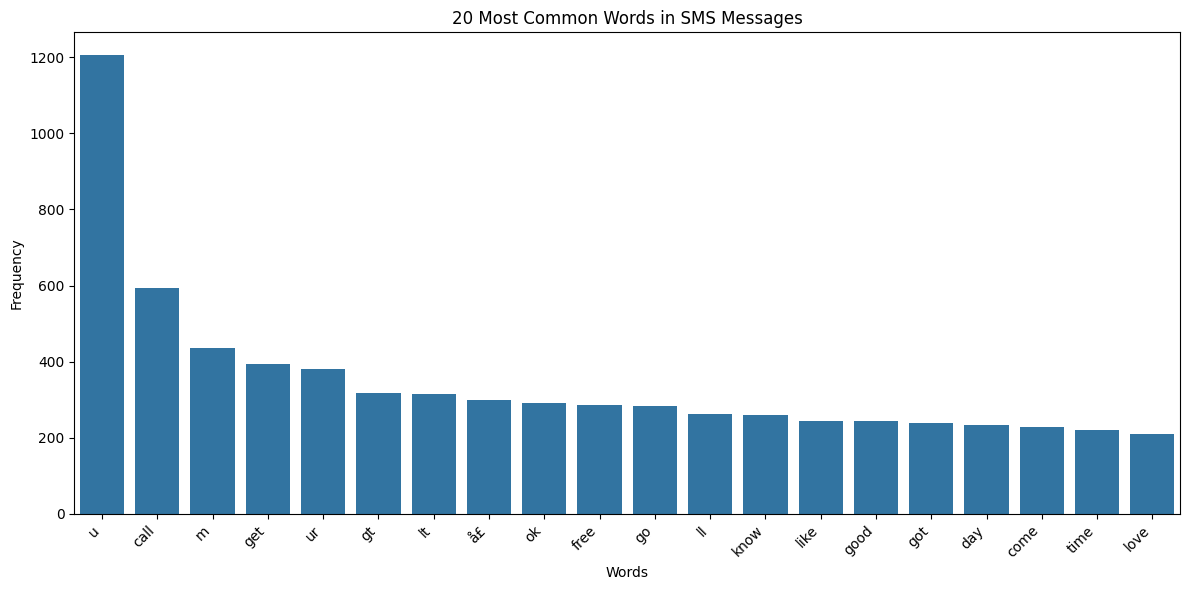

In [25]:
# Visualize most common words
plt.figure(figsize=(12, 6))
common_words = dict(word_freq.most_common(20))
sns.barplot(x=list(common_words.keys()), y=list(common_words.values()))
plt.title('20 Most Common Words in SMS Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:
# Let's also look at most common words in spam vs ham
spam_words = []
ham_words = []

for i, row in df.iterrows():
    if row['label'] == 'spam':
        spam_words.extend(row['filtered_tokens'])
    else:
        ham_words.extend(row['filtered_tokens'])

spam_word_freq = Counter(spam_words)
ham_word_freq = Counter(ham_words)

print("\nMost common words in SPAM messages:")
print(spam_word_freq.most_common(20))

print("\nMost common words in HAM messages:")
print(ham_word_freq.most_common(20))


Most common words in SPAM messages:
[('call', 357), ('å£', 294), ('free', 226), ('u', 181), ('txt', 170), ('p', 159), ('ur', 144), ('mobile', 128), ('text', 126), ('stop', 122), ('claim', 113), ('reply', 104), ('www', 98), ('prize', 93), ('get', 86), ('cash', 76), ('won', 76), ('uk', 73), ('nokia', 71), ('send', 70)]

Most common words in HAM messages:
[('u', 1024), ('m', 401), ('gt', 318), ('lt', 316), ('get', 308), ('ok', 287), ('ll', 259), ('go', 252), ('ur', 237), ('know', 236), ('call', 236), ('good', 233), ('like', 232), ('got', 231), ('come', 227), ('day', 209), ('time', 201), ('love', 199), ('going', 169), ('one', 167)]


In [27]:
# Create vectorization function (Bag of Words)
def create_bow_vector(tokens, vocabulary):
    """
    Create a bag-of-words vector for a message.
    
    Args:
        tokens (list): List of tokens (words) in the message
        vocabulary (set): Set of all unique words in the dataset
        
    Returns:
        dict: Dictionary with word counts for the message
    """
    # Initialize vector with zeros
    bow_vector = {word: 0 for word in vocabulary}
    
    # Count word occurrences
    word_counts = Counter(tokens)
    
    # Update the vector with word counts
    for word, count in word_counts.items():
        if word in vocabulary:  # Check if word is in vocabulary
            bow_vector[word] = count
    
    return bow_vector

# Test the vectorization function
sample_tokens = df['filtered_tokens'].iloc[0]
sample_bow = create_bow_vector(sample_tokens, vocabulary)

print("\nBag of Words vectorization example:")
print("Original tokens:", sample_tokens)
print("Resulting vector (showing non-zero entries):")
non_zero = {word: count for word, count in sample_bow.items() if count > 0}
print(non_zero)


Bag of Words vectorization example:
Original tokens: ['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
Resulting vector (showing non-zero entries):
{'cine': 1, 'point': 1, 'great': 1, 'amore': 1, 'got': 1, 'n': 1, 'buffet': 1, 'world': 1, 'la': 1, 'crazy': 1, 'jurong': 1, 'available': 1, 'e': 1, 'bugis': 1, 'wat': 1, 'go': 1}


In [28]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        """
        Initialize the Multinomial Naive Bayes classifier.
        
        Args:
            alpha (float): Smoothing parameter for Laplace smoothing.
                           Default is 1.0 (Laplace smoothing).
        """
        self.alpha = alpha  # Smoothing parameter
        self.class_priors = {}  # Prior probabilities P(class)
        self.word_probs = {}  # Conditional probabilities P(word|class)
        self.classes = None  # List of unique classes
        self.vocabulary = None  # Set of all unique words
    
    def fit(self, X_train, y_train):
        """
        Train the Naive Bayes classifier.
        
        Args:
            X_train (list): List of dictionaries, each containing word frequencies for a message
            y_train (list): List of labels (0 for ham, 1 for spam)
        """
        n_samples = len(y_train)
        self.classes = np.unique(y_train)
        
        # Calculate prior probabilities P(class)
        self.calculate_priors(y_train)
        
        # Store the vocabulary (unique words across all messages)
        self.vocabulary = set()
        for bow_vector in X_train:
            self.vocabulary.update(bow_vector.keys())
        
        # Calculate word probabilities for each class
        self.calculate_word_probabilities(X_train, y_train)
        
        return self
    
    def calculate_priors(self, y_train):
        """
        Calculate prior probabilities for each class.
        
        Args:
            y_train (list): List of labels
        """
        n_samples = len(y_train)
        # Count occurrences of each class
        class_counts = Counter(y_train)
        
        # Calculate prior probabilities
        for cls in self.classes:
            self.class_priors[cls] = class_counts[cls] / n_samples
    
    def calculate_word_probabilities(self, X_train, y_train):
        """
        Calculate conditional probabilities P(word|class) for all words in vocabulary.
        
        Args:
            X_train (list): List of dictionaries containing word frequencies
            y_train (list): List of labels
        """
        # Initialize word counts for each class
        word_counts = {cls: defaultdict(int) for cls in self.classes}
        # Initialize total word counts for each class
        total_counts = {cls: 0 for cls in self.classes}
        
        # Count word occurrences for each class
        for i, bow_vector in enumerate(X_train):
            cls = y_train[i]
            for word, count in bow_vector.items():
                word_counts[cls][word] += count
                total_counts[cls] += count
        
        # Calculate conditional probabilities with Laplace smoothing
        self.word_probs = {cls: {} for cls in self.classes}
        
        # Vocabulary size for Laplace smoothing
        vocab_size = len(self.vocabulary)
        
        for cls in self.classes:
            # Calculate denominator for smoothing: total words in class + alpha * vocabulary size
            denominator = total_counts[cls] + self.alpha * vocab_size
            
            # Calculate probabilities for each word in vocabulary
            for word in self.vocabulary:
                # Apply Laplace smoothing: (word_count + alpha) / (total_count + alpha * vocab_size)
                numerator = word_counts[cls].get(word, 0) + self.alpha
                self.word_probs[cls][word] = numerator / denominator
    
    def predict_proba(self, X_test):
        """
        Calculate posterior probabilities for each class.
        
        Args:
            X_test (list): List of dictionaries containing word frequencies for test messages
        
        Returns:
            list: List of predicted probabilities for each class
        """
        # Check if model has been trained
        if not self.word_probs:
            raise ValueError("Model not fitted. Call 'fit' first.")
        
        # List to store probabilities for each message
        all_probs = []
        
        for bow_vector in X_test:
            # Calculate log probabilities for each class
            log_probs = {cls: np.log(prior) for cls, prior in self.class_priors.items()}
            
            # Add log of word probabilities for each word in the message
            for word, count in bow_vector.items():
                if word in self.vocabulary:  # Only consider words in training vocabulary
                    for cls in self.classes:
                        # Multiply probability by word count (equivalent to adding log probabilities)
                        log_probs[cls] += count * np.log(self.word_probs[cls][word])
            
            # Convert log probabilities to actual probabilities
            # First, find the maximum log probability to avoid numerical underflow
            max_log_prob = max(log_probs.values())
            
            # Normalize and exponentiate
            probs = {}
            total_prob = 0
            for cls, log_prob in log_probs.items():
                probs[cls] = np.exp(log_prob - max_log_prob)
                total_prob += probs[cls]
            
            # Normalize to get proper probabilities
            for cls in probs:
                probs[cls] /= total_prob if total_prob > 0 else 1
            
            all_probs.append(probs)
        
        return all_probs
    
    def predict(self, X_test):
        """
        Predict class labels for test data.
        
        Args:
            X_test (list): List of dictionaries containing word frequencies
        
        Returns:
            list: Predicted labels for each message
        """
        # Get probabilities for each class
        all_probs = self.predict_proba(X_test)
        
        # Choose the class with highest probability for each message
        predictions = []
        for probs in all_probs:
            predictions.append(max(probs, key=probs.get))
        
        return predictions

In [29]:
## 4. Prepare Training and Testing Data

# Convert the messages to bag-of-words vectors
def prepare_data(df, vocabulary=None):
    """
    Prepare the data for training/testing by converting messages to bag-of-words vectors.
    
    Args:
        df (DataFrame): DataFrame containing the messages and their tokens
        vocabulary (set, optional): If provided, use this vocabulary instead of creating a new one
    
    Returns:
        tuple: X (bag-of-words vectors), y (labels), and vocabulary
    """
    # Create vocabulary if not provided
    if vocabulary is None:
        vocabulary = create_vocabulary(df['filtered_tokens'])
    
    # Convert messages to bag-of-words vectors
    X = []
    for tokens in df['filtered_tokens']:
        X.append(create_bow_vector(tokens, vocabulary))
    
    # Get labels
    y = df['label_num'].values
    
    return X, y, vocabulary

# Split the data into training and testing sets
def split_data(df, test_size=0.2, random_state=42):
    """
    Split the data into training and testing sets.
    
    Args:
        df (DataFrame): DataFrame containing the messages and labels
        test_size (float): Proportion of the dataset to include in the test split
        random_state (int): Random seed for reproducibility
    
    Returns:
        tuple: train_df, test_df (DataFrames for training and testing)
    """
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        stratify=df['label']  # Ensure proportional representation of classes
    )
    
    # Reset indices
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    return train_df, test_df

# Split the dataset
train_df, test_df = split_data(df)

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 4457
Testing set size: 1115


In [30]:
# Check class distribution in splits
print("\nClass distribution in training set:")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\nClass distribution in testing set:")
print(test_df['label'].value_counts(normalize=True) * 100)


Class distribution in training set:
label
ham     86.582903
spam    13.417097
Name: proportion, dtype: float64

Class distribution in testing set:
label
ham     86.636771
spam    13.363229
Name: proportion, dtype: float64


In [31]:
# Prepare training and testing data
X_train, y_train, vocabulary = prepare_data(train_df)
X_test, y_test, _ = prepare_data(test_df, vocabulary)

In [32]:
# Validate data shapes
print(f"\nNumber of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")
print(f"Vocabulary size: {len(vocabulary)}")


Number of training samples: 4457
Number of testing samples: 1115
Vocabulary size: 6952


In [33]:
# 5. Train and Evaluate the Model

# Train the Naive Bayes model
nb_classifier = MultinomialNaiveBayes(alpha=1.0)  # Using Laplace smoothing with alpha=1.0
nb_classifier.fit(X_train, y_train)

# Calculate prior probabilities
print("\nPrior probabilities:")
for cls, prior in nb_classifier.class_priors.items():
    class_name = "Spam" if cls == 1 else "Ham"
    print(f"{class_name}: {prior:.4f}")

# Make predictions on test data
y_pred = nb_classifier.predict(X_test)

# Get probability estimates
y_pred_proba = nb_classifier.predict_proba(X_test)
spam_probs = [probs[1] for probs in y_pred_proba]  # Extract spam probabilities


Prior probabilities:
Ham: 0.8658
Spam: 0.1342


In [34]:
# 6. Evaluation metrics
def evaluate_model(y_true, y_pred, y_pred_proba=None):
    """
    Evaluate the model using various metrics.
    
    Args:
        y_true (array): True labels
        y_pred (array): Predicted labels
        y_pred_proba (array, optional): Predicted probabilities for the positive class
    
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Calculate ROC curve and AUC if probabilities are provided
    roc_auc = None
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
    
    # Store results in dictionary
    results = {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'fpr': fpr if roc_auc is not None else None,
        'tpr': tpr if roc_auc is not None else None
    }
    
    return results

# Evaluate the model
evaluation = evaluate_model(y_test, y_pred, spam_probs)

In [35]:
# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {evaluation['accuracy']:.4f}")
print(f"Precision: {evaluation['precision']:.4f}")
print(f"Recall: {evaluation['recall']:.4f}")
print(f"F1-score: {evaluation['f1_score']:.4f}")
print(f"ROC AUC: {evaluation['roc_auc']:.4f}")


Evaluation Metrics:
Accuracy: 0.9874
Precision: 0.9720
Recall: 0.9329
F1-score: 0.9521
ROC AUC: 0.9842


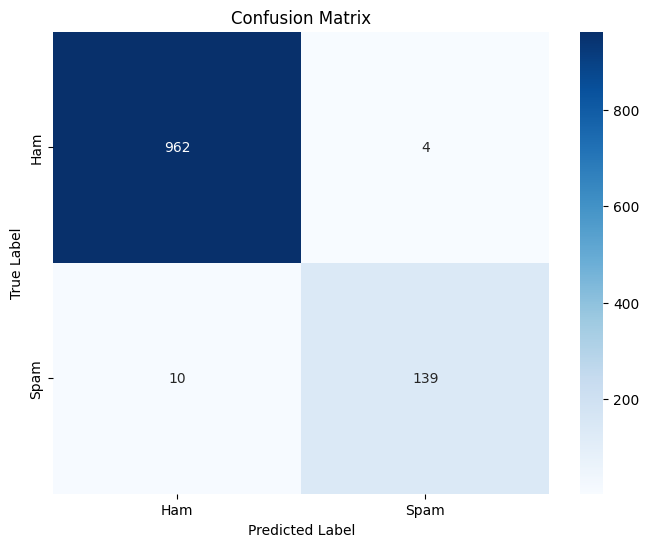

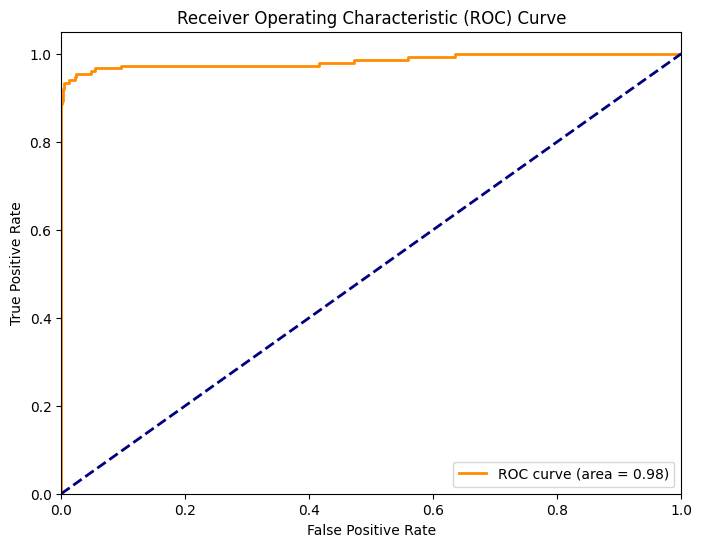

In [36]:
# 7. Visualize Results

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = evaluation['confusion_matrix']
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Ham', 'Spam'],
    yticklabels=['Ham', 'Spam']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr = evaluation['fpr'], evaluation['tpr']
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {evaluation["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()